# Create synthetic bathymetry 

## Cell 1: Create Domain and Grids

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm

# Domain and grid
dx = dy = 10
length = 2600
width = 800

x = np.arange(0, length, dx)
y = np.arange(-width//2, width//2, dy)
X, Y = np.meshgrid(x, y)

## Cell 2: Define Asymmetric Height Profile (Stoss to Lee)

In [5]:
# Asymmetric Gaussian along x (ice flow direction)
x0 = 600            # stoss peak location (m from nose)
sigma_stoss = 400   # controls steepness of stoss rise
sigma_lee = 1600    # controls gradual lee slope

# Piecewise asymmetric Gaussian (sharp rise, gentle fall)
height_profile = np.where(
    X <= x0,
    np.exp(-((X - x0)**2) / (2 * sigma_stoss**2)),
    np.exp(-((X - x0)**2) / (2 * sigma_lee**2))
)

## Cell 3: Apply Width and Generate Drumlin Surface

In [7]:
# Cross-sectional Gaussian width
W_max = 600
W = W_max * height_profile

# Modulate height and cross-profile
H_max = 190  # peak height in meters
Z = H_max * height_profile * np.exp(- (2 * Y / W)**2)

# Set base elevation to zero
Z = Z - np.max(Z)

## Cell 4: Visualize

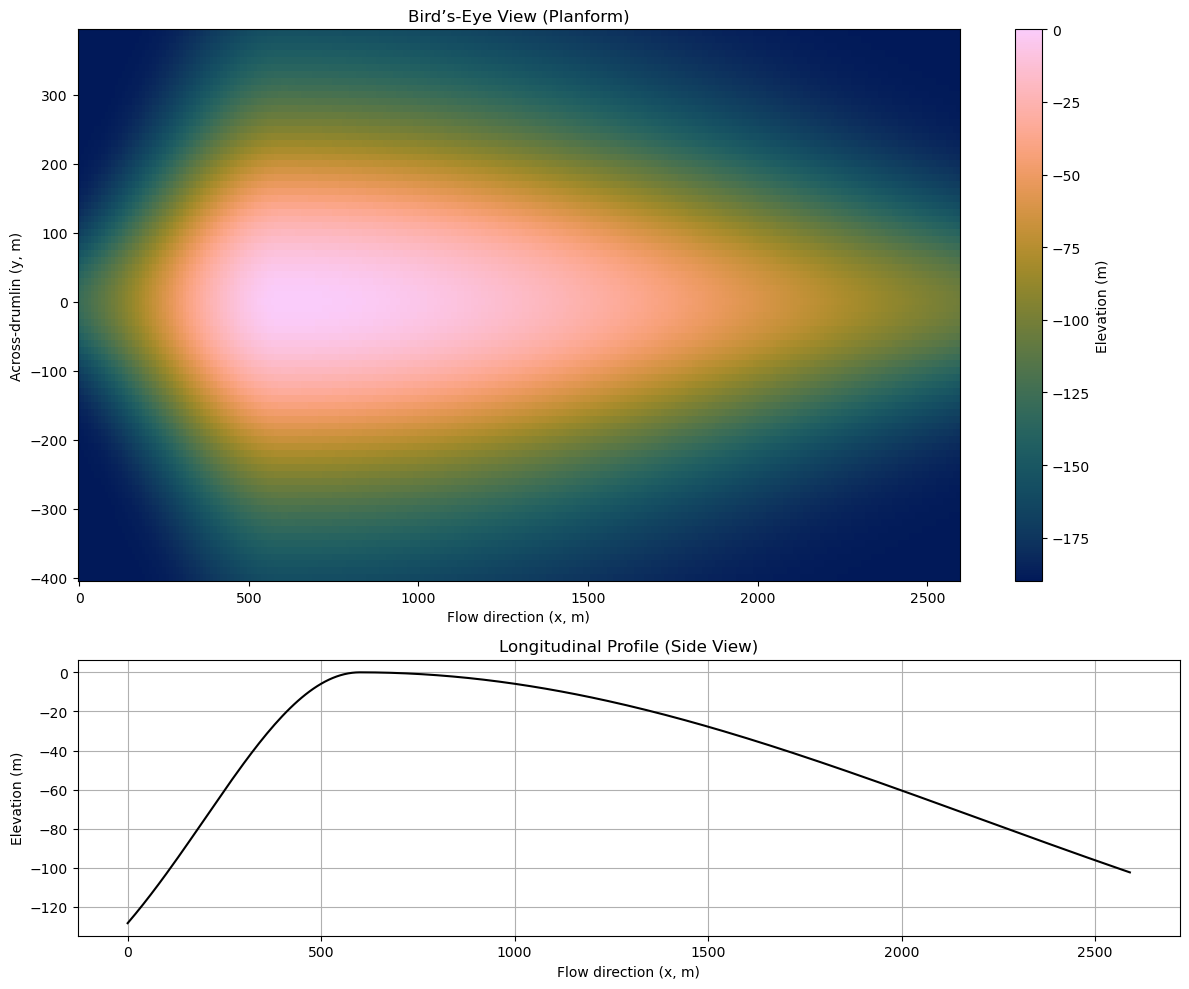

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Bird's-eye view (top panel)
c1 = ax1.pcolormesh(X, Y, Z, shading='auto', cmap=cm.batlow)
fig.colorbar(c1, ax=ax1, orientation='vertical', label='Elevation (m)')
ax1.set_title('Bird’s-Eye View (Planform)')
ax1.set_ylabel('Across-drumlin (y, m)')
ax1.set_xlabel('Flow direction (x, m)')

# Longitudinal side view along y = 0 (drumlin axis)
centerline = Z[Z.shape[0] // 2, :]  # middle row
ax2.plot(x, centerline, color='black')
ax2.set_title('Longitudinal Profile (Side View)')
ax2.set_xlabel('Flow direction (x, m)')
ax2.set_ylabel('Elevation (m)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Next step

# Add Thin Subglacial Water Layer

## Cell 6: Initialize Uniform Subglacial Water Layer

In [13]:
# Define a uniform subglacial water layer thickness
# Value based on typical near-grounding zone cavity heights (0.5–1.0 m)

h0 = 0.75  # initial water thickness in meters
H_water = np.full_like(Z, h0)  # same shape as bed topography

# Define Tidal Pressure Forcing Over Time

### Import tidal model CAT2008v2023

In [16]:
import os
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# import tide programs
import pyTMD.io
import pyTMD.tools
import datetime

#### Set paths to data file

You need the netCDF file CATS2008_v2023.nc in a directory called CATS2008-v2023 for pyTMD to find it like

    Profile_FFT.ipynb

    CATS2008-v2023

        CATS2008_v2023.nc



In [18]:
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.value = 'CATS2008-v2023'
TMDwidgets.directory.value = "."

# Initialise the model
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

In [19]:
# Set model parameters
lon = -112.4
lat = -74.4
time_range = np.arange(datetime.datetime(2019,3,22), datetime.datetime(2020,9,4), datetime.timedelta(hours=1))
model = pyTMD.io.model(verify=False).elevation(TMDwidgets.model.value)
model.parse_constituents()
# calculate tide elevations
tide = pyTMD.compute.tide_elevations(lon, lat, time_range,
    DIRECTORY=TMDwidgets.directory.value, TYPE='time series', 
    MODEL=TMDwidgets.model.value, GZIP=TMDwidgets.compress.value,
    EPSG=4326, TIME='datetime', EXTRAPOLATE=True, CUTOFF=20).squeeze()

# Cell 8: Convert Tidal Height to Pressure Forcing

In [21]:
# Constants
g = 9.81               # m/s²
rho_water = 1028       # kg/m³
A_M2 = 1.0             # tidal amplitude in meters
T_M2 = 12.42 * 3600    # tidal period (M2) in seconds
omega = 2 * np.pi / T_M2

# Time vector: simulate ~1.5 tidal cycles
dt = 60                         # time step in seconds
t_end = int(1.5 * T_M2)
time = np.arange(0, t_end, dt)

# Tidal surface slope from grounded ice (upstream) to open ocean (downstream)
eta_start = 0.0    # upstream tidal height (m)
eta_end = 1.0      # downstream tidal height (m)
eta_profile = np.linspace(eta_start, eta_end, X.shape[1])  # shape: (x,)

# Compute pressure field over time: shape (time, x)
P_tide_x = np.array([
    rho_water * g * eta_profile * np.sin(omega * t)
    for t in time
])  # units: Pascals

# Cell 9: Compute Time-Varying Hydraulic Potential Field

compute the hydraulic potential field at each time step:
ϕ(x,y,t)=ρg(zb+h(x,y))+Ptide(t)

Where:

    zb​ is the bed elevation (Z)

    h(x,y) is the water layer thickness (H_water)

    Ptide(t) is a scalar (applied uniformly)

We'll store the full time-varying potential in a 3D array.

In [24]:
# Pre-allocate 3D hydraulic potential field
phi = np.empty((len(time), *Z.shape))  # shape: (time, y, x)

# Compute hydraulic potential at each time step
for i in range(len(time)):
    # Expand 1D pressure profile (shape x) into 2D (shape y, x)
    P_field = np.tile(P_tide_x[i], (Z.shape[0], 1))  # shape: (y, x)

    # Total hydraulic potential: bed + water + tidal pressure
    phi[i] = rho_water * g * (Z + H_water) + P_field

## Cell 10: Compute Water Fluxes qxqx​, qyqy​

compute the hydraulic gradients and then the water fluxes using a simple Darcy-like law:
q=−k⋅h3⋅∇ϕ

Where:

    h is the water thickness (H_water)

    ∇ϕ is the spatial gradient of hydraulic potential

    k is an effective hydraulic conductivity (tunable parameter)

We’ll compute qxqx​ and qyqy​ at each time step.

In [27]:
# Set effective conductivity
k = 1e-3  # m²/s/Pa (example value for thin-film subglacial system)

# Grid spacing
dx = dy = 10  # m

# Preallocate flux arrays
qx = np.empty_like(phi)
qy = np.empty_like(phi)

# Loop over time to compute gradients and fluxes
for i in range(len(time)):
    dphidx, dphidy = np.gradient(phi[i], dx, dy)
    qx[i] = -k * H_water**3 * dphidx
    qy[i] = -k * H_water**3 * dphidy


## Cell 11: Plot Water Flux Vectors and Magnitude

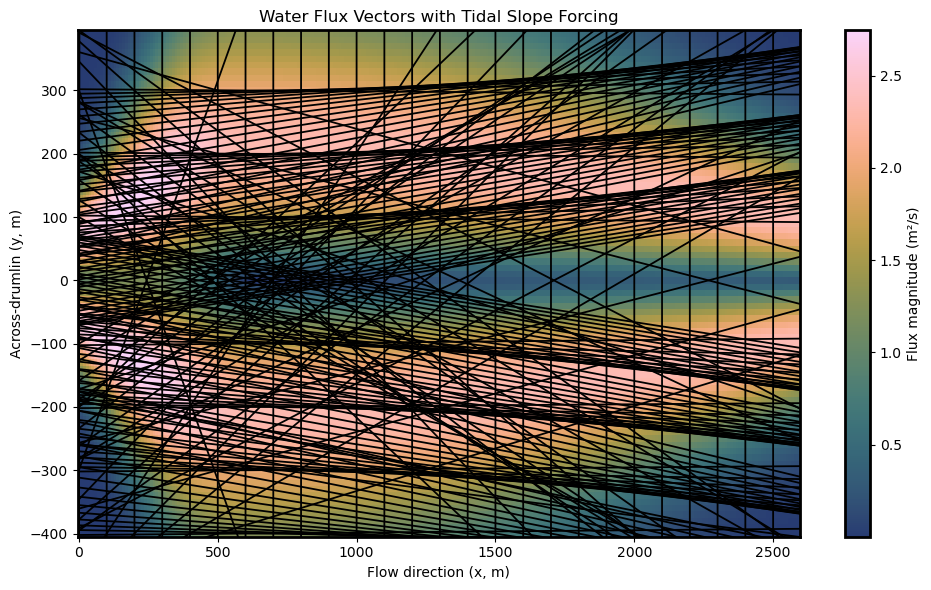

In [29]:
# Choose time index (e.g., near peak tide)
i_plot = np.argmax(np.sum(phi, axis=(1, 2)))  # total potential max

# Compute flux magnitude
flux_mag = np.sqrt(qx[i_plot]**2 + qy[i_plot]**2)

# Subsample for clarity
step = 10
Xq = X[::step, ::step]
Yq = Y[::step, ::step]
U = qx[i_plot][::step, ::step]
V = qy[i_plot][::step, ::step]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(X, Y, flux_mag, shading='auto', cmap=cm.batlow, alpha=0.85)
plt.colorbar(c, label='Flux magnitude (m²/s)')

ax.quiver(Xq, Yq, U, V, color='black', scale=2e-4, width=0.0025, pivot='middle')

ax.set_title('Water Flux Vectors with Tidal Slope Forcing')
ax.set_xlabel('Flow direction (x, m)')
ax.set_ylabel('Across-drumlin (y, m)')
plt.tight_layout()
plt.show()


Background Colors: Water Flux Magnitude

    The color map (cm.batlow) shows flux magnitude in units of m2/sm2/s, calculated as:
    ∣q∣=qx2+qy2
    ∣q∣=qx2​+qy2​

    ​

    Brighter areas = zones of faster water movement, likely due to:

        Steeper hydraulic gradients

        Topographic focusing

        Tidal pressure peak amplifying potential

Black Arrows: Water Flow Direction

    The arrows show the horizontal flow vectors:

        qxqx​: downslope (flow direction)

        qyqy​: across the drumlin

    Arrow length = relative speed, and angle = direction

    Subsampled for clarity every 5 grid points

notes
🧠 Interpretation
🏹 Arrows: Directional Water Flow

    You now see consistent flow bias in the x-direction, especially near the core of the drumlin — a direct result of the horizontal tidal gradient.

    Many arrows show deflection outward from the central axis, suggesting that:

        Flow is interacting with the drumlin flanks,

        Topographic steering is stronger than under uniform pressure forcing.

🎨 Background Colors: Flux Magnitude

    Higher fluxes on the stoss flanks and lee margins, consistent with:

        Stronger pressure gradients at those points,

        Flow accelerating around the sides of the drumlin.

        

## Cell 12: Compute Time-Integrated Water Flux Magnitude

In [33]:
# Initialize cumulative flux field
cumulative_flux = np.zeros_like(Z)  # same shape as domain (y, x)

# Time step size in seconds (same as used previously)
dt = 60

# Loop over time to integrate flux magnitude without memory overflow
for i in range(len(time)):
    flux_mag = np.sqrt(qx[i]**2 + qy[i]**2)
    cumulative_flux += flux_mag * dt  # increment total m² flux per cell

# Cell 13: Plot cumulative water flux map

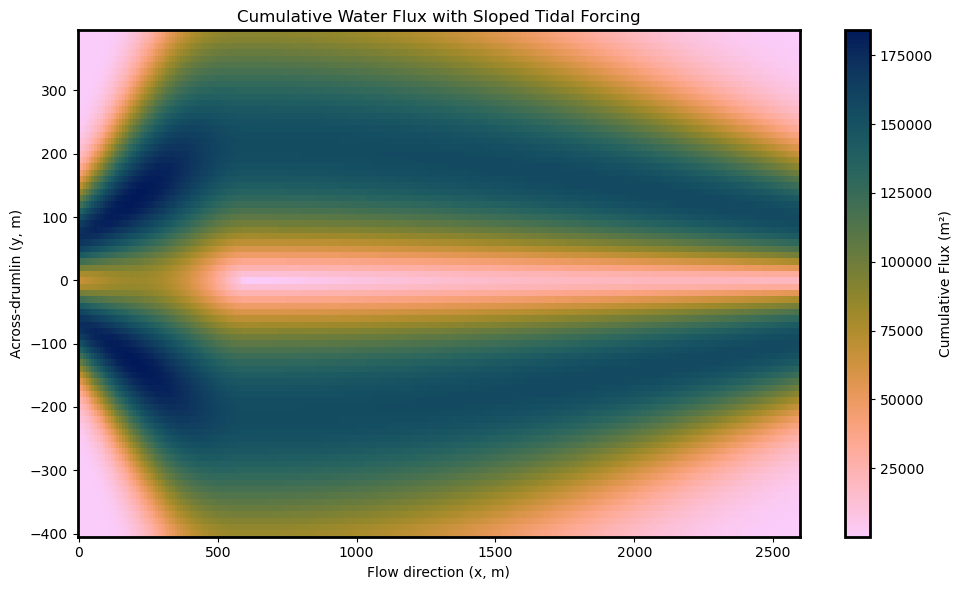

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cumulative water flux (units: m² of water passed through each cell)
c = ax.pcolormesh(X, Y, cumulative_flux, shading='auto', cmap=cm.batlow_r)
plt.colorbar(c, label='Cumulative Flux (m²)')

# Labels and formatting
ax.set_title('Cumulative Water Flux with Sloped Tidal Forcing')
ax.set_xlabel('Flow direction (x, m)')
ax.set_ylabel('Across-drumlin (y, m)')
plt.tight_layout()
plt.show()

Color Map: Total Water Throughput (m²)

    Represents how much water passed through each grid cell over ~18.6 hrs.

    Units are area of water moved through per cell (not velocity).

1. Centerline Concentration

    Bright core down the central x-axis → persistent flow path over drumlin crest.

    Suggests that tidal slope does not fully push flow around the drumlin — instead, it focuses along topographic lows, potentially feeding incision.

2. Dark bands flanking the stoss (left side)

    These are zones of increased gradient, where water accelerates around the ramp-up.

    Could correspond to shear zones or incipient side-channel development if erosion is active.

3. Tapering flux toward the lee

    This matches expectations: lower slope and velocity, wider spread.

    Suggests reduced focusing past the drumlin, with energy dissipated.

## Cell 14 Cumulative erosion potential

In [39]:
# Initialize erosion proxy field
erosion_potential = np.zeros_like(Z)
dt = 60  # seconds
alpha = 2  # erosion sensitivity exponent (1 = linear, 2 = stronger focusing)

# Time-integrated erosion potential
for i in range(len(time)):
    flux_mag = np.sqrt(qx[i]**2 + qy[i]**2)
    erosion_potential += (flux_mag**alpha) * dt

Erosion Potential Proxy

We’ll use a simplified relationship:
E(x,y)∝∣q∣α
E(x,y)∝∣q∣α

Where:

    ∣q∣∣q∣ is the flux magnitude (from each time step)

    αα is a tunable exponent (commonly 1–2) — controls erosion sensitivity

    Higher values → stronger potential for melt-driven or shear-driven erosion

# Cell 15

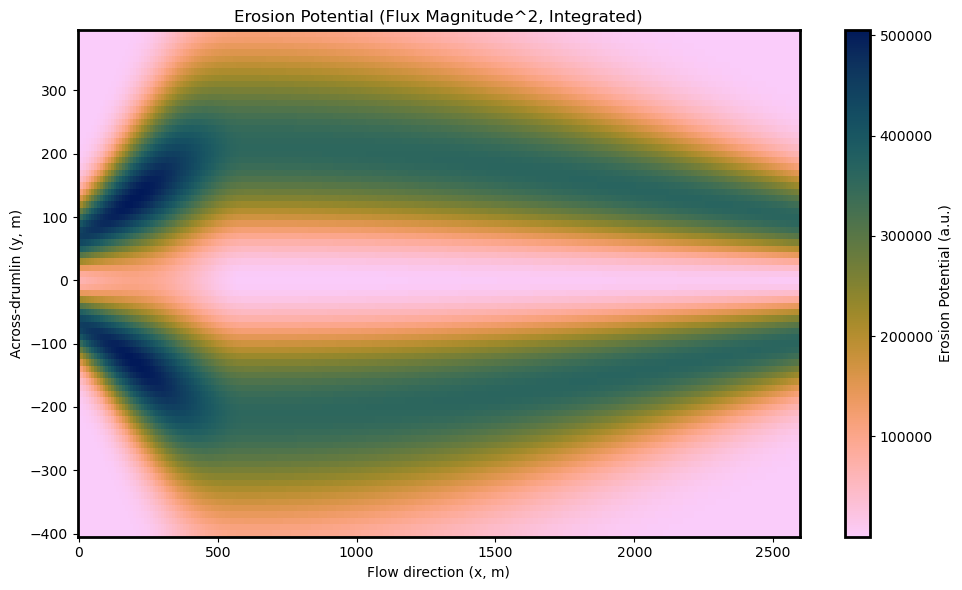

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot erosion potential (arbitrary units)
c = ax.pcolormesh(X, Y, erosion_potential, shading='auto', cmap=cm.batlow_r)
plt.colorbar(c, label='Erosion Potential (a.u.)')

# Labels and formatting
ax.set_title(f'Erosion Potential (Flux Magnitude^{alpha}, Integrated)')
ax.set_xlabel('Flow direction (x, m)')
ax.set_ylabel('Across-drumlin (y, m)')
plt.tight_layout()
plt.show()
